# 0.筛选数据流程
1. 读取12个npy文件
2. 根据需要筛选出符合要求的城市id
    1. 基于SQL的查询
    2. 抛弃nan值过多的城市ID
3. 制作时空数据：
    1. 12个npy中筛选出来然后合并
    2. 事件时空数据筛选出来
    3. 两个时空数据合并
4. 制作时间维度的特征：时间戳、天气
5. 制作节点维度的特征：图像、POI、节点类型road_type、邻接矩阵、距离矩阵
    1. 先制作
    2. 根据符合要求的节点id或者idx进行筛选

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import duckdb

data_dir = Path("/root/xtraffic/versions/7")
save_path=Path("/root/code/Framework/dataset")

In [ ]:
# # === 统计缺失率 ===
# npy_files = sorted(data_dir.glob("p*.npy"))
# nan_counts = np.zeros(num_nodes, dtype=np.int64)
# total_counts = np.zeros(num_nodes, dtype=np.int64)

# for path in npy_files:
#     arr = np.load(path)  # 形状 (T_i, 16972, 3)
#     if arr.ndim != 3 or arr.shape[1] != num_nodes:
#         raise ValueError(f"{path} shape mismatch: {arr.shape}")
#     nan_counts += np.isnan(arr).sum(axis=(0, 2))
#     total_counts += arr.shape[0] * arr.shape[2]

# miss_rate = nan_counts / np.maximum(total_counts, 1)

# # === 按阈值筛选并保存 ===
# threshold = 0.2
# keep_indices = np.where(miss_rate <= threshold)[0]
# drop_indices = np.where(miss_rate > threshold)[0]

# print(f"Keep count: {len(keep_indices)}, Drop count: {len(drop_indices)}")

# # 保存 keep_indices 方便下次直接用
# station_not_nan_path = data_dir / "station_not_nan.npy"
# np.save(station_not_nan_path, keep_indices)
# print(f"✅ 已保存 {len(keep_indices)} 个有效节点到 {station_not_nan_path}")

In [ ]:
# === 加载元数据 ===
keep_indices = np.load(data_dir / "station_not_nan.npy")
node_order = np.load(data_dir / "node_order.npy")
meta_path = data_dir / "sensor_meta_feature.csv"
match_incidents_path = "/root/xtraffic/match_incidents.csv"
incident_path = "/root/xtraffic/versions/7/incidents_y2023.csv"
try:
    df_meta = pd.read_csv(meta_path)
except Exception:
    df_meta = pd.read_csv(meta_path, sep="\t")
try:
    df_match_incidents = pd.read_csv(match_incidents_path)
except Exception:
    df_match_incidents = pd.read_csv(match_incidents_path, sep="\t")

df_incidents = pd.read_csv(incident_path, sep="\t")

# 1. 读取12个npy文件

In [4]:
# 1.把12个npy拼在一起
npy_files = sorted(data_dir.glob("p*.npy"))
data_list = []
for path in npy_files:
    arr = np.load(path)  # 形状 (T_i, 16972, 3)
    data_list.append(arr)
    print(f"Loaded {path} with shape {arr.shape}")
# full_data = np.concatenate(data_list, axis=0)  # 形状 (T_total, 16972, 3)
# print(f"Full data shape: {full_data.shape}")

Loaded /root/xtraffic/versions/7/p01_done.npy with shape (8928, 16972, 3)
Loaded /root/xtraffic/versions/7/p02_done.npy with shape (8064, 16972, 3)
Loaded /root/xtraffic/versions/7/p03_done.npy with shape (8928, 16972, 3)
Loaded /root/xtraffic/versions/7/p04_done.npy with shape (8640, 16972, 3)
Loaded /root/xtraffic/versions/7/p05_done.npy with shape (8928, 16972, 3)
Loaded /root/xtraffic/versions/7/p06_done.npy with shape (8640, 16972, 3)
Loaded /root/xtraffic/versions/7/p07_done.npy with shape (8928, 16972, 3)
Loaded /root/xtraffic/versions/7/p08_done.npy with shape (8928, 16972, 3)
Loaded /root/xtraffic/versions/7/p09_done.npy with shape (8640, 16972, 3)
Loaded /root/xtraffic/versions/7/p10_done.npy with shape (8928, 16972, 3)
Loaded /root/xtraffic/versions/7/p11_done.npy with shape (8640, 16972, 3)
Loaded /root/xtraffic/versions/7/p12_done.npy with shape (8928, 16972, 3)


# 2.根据需要筛选出符合要求的城市id
    1. 基于SQL的查询
    2. 抛弃nan值过多的城市ID


df_meta 列说明：
- Fwy Name: 传感器所在高速公路的名称, 例如SR1-N.
-  District: 加州交通局 (Caltrans) 所属的行政区编号.
-   County: 传感器所在的县，例如 “Orange” 或 “Los Angeles”.
-   City: 传感器所在的城市或行政区域，例如 “Marina”, “Oakland”.
-   Abs PM: 绝对桩号 (Absolute Postmile)，表示传感器沿高速公路起点的累计里程 (单位: 英里).
-   Length: 车道的总长度，单位为米.
-   station_id: 传感器站点的唯一标识符.
-   Name: 站点名称或描述，一般由高速公路名与桩号信息组合而成.
-   Type: 道路类型，例如主干道 (Mainline)、入口匝道 (On Ramp)、出口匝道 (Off Ramp).
-   Sensor Type: 传感器类型，例如雷达 (Radar)、线圈检测器 (Loop Detector)、磁感应传感器 (Magnetometer)和NaN.
-   HOV: 是否为高乘载车道 (HOV, High-Occupancy Vehicle)，取值如 “Yes” 或 “No”.
-   Road Width: 道路的总宽度 (ft).
-   Lane Width: 每条车道的平均宽度 (ft).
-  Inner Shoulder Width: 内侧路肩 (靠近中央分隔带一侧) 的宽度 (ft).
- Outer Shoulder Width: 外侧路肩 (靠近道路外缘一侧) 的宽度 (ft).
-   Design Speed Limit: 道路的设计限速 (mph).
-   Inner Median Type: 中央隔离带的类型,例如Paved - Roadway Use, Paved - No Roadway Use.
-   Inner Median Width: 中央隔离带的宽度 (ft).
-   Terrain: 地形特征，例如平原 (Flat)、Rolling.
-  Population: 道路周围区域的人口或开发密度类型，例如城市 (Urbanized).
-   Barrier: 道路旁防护设施的描述，例如防撞护栏 (Guardrail)、无 (None).
-   Surface: 路面材质粗糙程度描述.
-   Roadway Use: 道路的主要用途.
-  Lat: 传感器位置的地理纬度.
-   Lng: 传感器位置的地理经度.
-   Direction: 车道的行驶方向，例如北向 (Northbound)、东向 (Eastbound).
-   Fwy: 高速公路编号或简称.


In [ ]:
# 空白点的范围查询
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # 假设 df_meta 已经读好了
# df_orig = df_meta.copy()  # 保留一份原始数据，用来算经纬度边界

# # ===== 1. 按要求清洗 df_meta =====
# df = df_meta.copy()

# # 删除 City 和 Sensor Type 列
# cols_to_drop = ["City", "Sensor Type"]
# df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# # 删除 Lat、Lng 为空的行
# df = df.dropna(subset=["Lat", "Lng"])

# # Length 空值填 0
# if "Length" in df.columns:
#     df["Length"] = df["Length"].fillna(0)

# # ===== 2. 定义要检查缺失的 10 个列 =====
# cols_check = [
#     "Road Width",
#     "Lane Width",
#     "Inner Shoulder Width",
#     "Outer Shoulder Width",
#     "Design Speed Limit",
#     "Inner Median Type",
#     "Inner Median Width",
#     "Terrain",
#     "Population",
#     "Barrier",
# ]

# print("====== 缺失统计 ======")
# n = len(df)

# for col in cols_check:
#     if col not in df.columns:
#         print(f"{col:30s} 不存在该列，跳过")
#         continue
#     missing = df[col].isna().sum()
#     pct = missing / n * 100
#     print(f"{col:30s} 缺失数量: {missing:5d}   缺失占比: {pct:6.2f}%")

# # ===== 3. 找出在这 10 列中全部缺失的 station_id =====
# # 只有在 df 中存在的列才参与 all()
# cols_exist = [c for c in cols_check if c in df.columns]
# all_missing_mask = df[cols_exist].isna().all(axis=1)

# missing_station_df = df.loc[all_missing_mask].copy()
# missing_station_ids = missing_station_df["station_id"]

# print("\n====== 在上述列中全部缺失的 station_id ======")
# print("数量：", len(missing_station_ids))
# print("station_id 示例（前 20 个）：", missing_station_ids.head(20).tolist())

# # 收集这些节点的经纬度
# miss_lat = missing_station_df["Lat"].to_numpy()
# miss_lng = missing_station_df["Lng"].to_numpy()

# # ===== 4. 计算原始数据的经纬度极值（边界范围）=====
# # 只在原始数据里筛掉 Lat/Lng 为 NaN 的行再算极值
# df_orig_ll = df_orig.dropna(subset=["Lat", "Lng"])

# lat_min = df_orig_ll["Lat"].min()
# lat_max = df_orig_ll["Lat"].max()
# lng_min = df_orig_ll["Lng"].min()
# lng_max = df_orig_ll["Lng"].max()

# print(f"\n经纬度边界：")
# print(f"Lat  ∈ [{lat_min}, {lat_max}]")
# print(f"Lng  ∈ [{lng_min}, {lng_max}]")

# # ===== 5. 画图展示缺失节点的分布 + 边界框 =====
# plt.figure(figsize=(8, 6))

# # 缺失节点散点
# plt.scatter(miss_lng, miss_lat, s=10, alpha=0.8, label="stations with all 10 fields missing")

# # 边界框（用经纬度极值画一个矩形）
# rect_x = [lng_min, lng_max, lng_max, lng_min, lng_min]
# rect_y = [lat_min, lat_min, lat_max, lat_max, lat_min]
# plt.plot(rect_x, rect_y, linewidth=1.5, label="boundary of all stations")

# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.title("Spatial distribution of stations with all 10 fields missing")
# plt.legend()
# plt.tight_layout()

# # 如需保存图片：
# # plt.savefig("missing_stations_distribution.png", dpi=300)

# plt.show()

In [5]:
import pandas as pd

# df_meta 已经读取
df = df_meta.copy()

# ===== 1. 删除 City 和 Sensor Type 列 =====
cols_to_drop = ["City", "Sensor Type"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# ===== 2. 删除 Lat、Lng 为空的行 =====
df = df.dropna(subset=["Lat", "Lng","Barrier"])

# ===== 3. Length 空值填 0 =====
if "Length" in df.columns:
    df["Length"] = df["Length"].fillna(0)


df_meta = df

print("\n=== 传感器元特征示例 ===")
print("数据尺寸：", df_meta.shape)

missing_counts = df_meta.isnull().sum()
missing_ratio = (missing_counts / len(df_meta) * 100).round(2)

print("\n=== 📉 缺失值统计（逐行输出完整） ===")
for col in df_meta.columns:
    print(f"{col:<30} 缺失数量: {missing_counts[col]:>6}   缺失占比: {missing_ratio[col]:>6.2f}%")



=== 传感器元特征示例 ===
数据尺寸： (16116, 25)

=== 📉 缺失值统计（逐行输出完整） ===
Fwy Name                       缺失数量:      0   缺失占比:   0.00%
District                       缺失数量:      0   缺失占比:   0.00%
County                         缺失数量:      0   缺失占比:   0.00%
Abs PM                         缺失数量:      0   缺失占比:   0.00%
Length                         缺失数量:      0   缺失占比:   0.00%
station_id                     缺失数量:      0   缺失占比:   0.00%
Name                           缺失数量:      7   缺失占比:   0.04%
Type                           缺失数量:      0   缺失占比:   0.00%
HOV                            缺失数量:      0   缺失占比:   0.00%
Road Width                     缺失数量:      0   缺失占比:   0.00%
Lane Width                     缺失数量:      0   缺失占比:   0.00%
Inner Shoulder Width           缺失数量:      0   缺失占比:   0.00%
Outer Shoulder Width           缺失数量:      0   缺失占比:   0.00%
Design Speed Limit             缺失数量:      0   缺失占比:   0.00%
Inner Median Type              缺失数量:      0   缺失占比:   0.00%
Inner Median Width             缺失数量:   

In [6]:
# 1. 把keep_station_ids转换成pandas能用的格式
station_to_index = {int(sid): idx for idx, sid in enumerate(node_order)}
# 映射得到保留节点的编号
keep_station_ids = node_order[keep_indices].astype(int)
keep_station_df = pd.DataFrame({
    "station_id": keep_station_ids,
    "node_index": [station_to_index[int(sid)] for sid in keep_station_ids]
})
station2idx_keep = dict(zip(keep_station_df["station_id"], keep_station_df["node_index"]))
print("keep_station_df head:")
print(keep_station_df.head(10))

for df in [df_match_incidents, df_incidents]:
    df["incident_id"] = pd.to_numeric(df["incident_id"], errors="coerce")
    df.dropna(subset=["incident_id"], inplace=True)
    df["incident_id"] = df["incident_id"].astype(int)

# 2.根据需求用 DuckDB 查询
sac_df = duckdb.query("""
SELECT 
    A.Type AS road_type,
    A.station_id,
    K.node_index,
FROM df_meta AS A
JOIN keep_station_df AS K
    ON A.station_id = K.station_id
WHERE A.County = 'Sacramento'
ORDER BY K.node_index
""").to_df()

# sac_keep = sac_df[sac_df["station_id"].isin(kssheep_station_ids)].reset_index(drop=True)
# print(f"Sacramento in keep set: {len(sac_keep)} stations")
print("sac_df head:")
print(sac_df.head())
print(f"✅ 筛选完成，Sacramento 有效站点共 {len(sac_df)} 个")

# 根据节点做特征匹配
# 在node_order_path中找到sac_df里的station_id对应的index：sac_node_indices，基于这个可以在时空数据中筛选，在矩阵里筛选
sac_node_indices = sac_df["node_index"].to_numpy()
print(sac_node_indices.min(),sac_node_indices.max())


keep_station_df head:
   station_id  node_index
0   501021032           1
1      314421           2
2    10119710           3
3     1211784           4
4      819941           5
5      767801           9
6      407153          11
7     1093510          13
8      769985          14
9    10120910          15
sac_df head:
  road_type  station_id  node_index
0  Off Ramp      314421           2
1  Off Ramp      314615          39
2       HOV      315883         101
3       HOV      315901         110
4  Off Ramp      317138         126
✅ 筛选完成，Sacramento 有效站点共 517 个
2 16951


In [36]:
# print(df_meta.head)
city_df = duckdb.query("""
SELECT 
    A.County,
    A.station_id,
    A.Lat,
    A.Lng,
    K.node_index
FROM df_meta AS A
JOIN keep_station_df AS K
    ON A.station_id = K.station_id
ORDER BY A.County, K.node_index
""").to_df()
city_df.to_csv(save_path / "city_lat_lng.csv")

# 3. 制作时空数据：
    1. 12个npy中筛选出来然后合并
    2. 事件时空数据筛选出来
    3. 两个时空数据合并


In [7]:
data_keep_list=[]
for arr in data_list:
    arr_to_keep=arr[:,sac_node_indices,:]
    data_keep_list.append(arr_to_keep)
    
data_keep = np.concatenate(data_keep_list, axis=0)  # (T_total, N_sac, 3)
print(f"✅ Sacramento 时空数据 shape: {data_keep.shape}")

✅ Sacramento 时空数据 shape: (105120, 517, 3)


In [12]:

import numpy as np
import pandas as pd
import tqdm


def time_to_5min_index(dt_input, start="2023-01-01 00:00:00"):
    """
    将 dt_input (单个值或数组) 映射到以 start 为起点、
    5 分钟为间隔的索引。
    """
    dt_series = pd.Series(dt_input)
    dt_series = pd.to_datetime(dt_series, errors="coerce")
    dt_floor = dt_series.dt.floor("5T")
    start_ts = pd.Timestamp(start)
    idx = ((dt_floor - start_ts) / pd.Timedelta(minutes=5)).astype("int64")
    if idx.size == 1:
        return int(idx.iloc[0])
    return idx.to_numpy()


def station_to_idx_vec(station_ids, station2idx):
    return np.array([station2idx.get(int(s), -1) for s in station_ids], dtype=np.int32)


# ================================
# 根据 df_match_incidents 生成 incident_tensor
#  - duration 覆盖多时间 bin
#  - 冲突时 dis 小的优先覆盖
# ================================

# df_match_incidents 必须至少包含：
# ['station_id', 'dt', 'incident_type', 'duration', 'dis']
# duration 单位：分钟
# dis 单位与 Abs PM 一致（你前面代码里是 abs postmile 差）

T_total = 105120   # 2023年全年的 5min bin 数
N_total = 16972    # 节点数

incident_tensor = np.zeros((T_total, N_total, 1), dtype=np.int8)

# 记录当前每个 (t, n) 位置已有标签的最小 dis
best_dis_tensor = np.full((T_total, N_total), np.inf, dtype=np.float32)

for row in tqdm.tqdm(df_match_incidents.itertuples(),
                     total=len(df_match_incidents),
                     desc="Processing incidents"):

    # 站点 index
    station_idx = station2idx_keep.get(row.station_id, -1)
    if station_idx == -1:
        continue

    # 起始时间 index（floor 到 5min）
    start_idx = time_to_5min_index(row.dt)
    if not (0 <= start_idx < T_total):
        continue

    # duration（分钟）
    dur_min = getattr(row, "duration", 0)
    if pd.isna(dur_min) or dur_min <= 0:
        dur_min = 5  # 至少覆盖 1 个 5min bin

    # duration -> 覆盖多少个 5min bin
    n_bins = int(np.ceil(dur_min / 5.0))
    end_idx = min(start_idx + n_bins, T_total)

    # 当前事件的 dis
    dis_val = getattr(row, "dis", np.inf)
    if pd.isna(dis_val):
        dis_val = np.inf

    # 取出该时间段/站点已有的 best_dis
    cur_best = best_dis_tensor[start_idx:end_idx, station_idx]

    # 只在 dis 更小时覆盖
    mask = dis_val < cur_best
    if np.any(mask):
        incident_tensor[start_idx:end_idx, station_idx, 0][mask] = row.incident_type
        best_dis_tensor[start_idx:end_idx, station_idx][mask] = dis_val


# ================================
# 后续步骤（NaN统计、填0、子区域拼接）保持不变
# ================================

# 1) NaN 统计
T, N, F = data_keep.shape
nan_mask = np.isnan(data_keep)
total_nan = nan_mask.sum()
nan_per_feature = nan_mask.sum(axis=(0, 1))
nan_per_node = nan_mask.sum(axis=(0, 2))

print(f"总 NaN 数量: {total_nan}")
for fi in range(F):
    print(f"特征 {fi} 中的 NaN 数量: {nan_per_feature[fi]}")
print("NaN 最多的前 10 个节点 (node_index, NaN 数量):")
top_nodes = np.argsort(-nan_per_node)[:10]
for ni in top_nodes:
    print(ni, nan_per_node[ni])

# 2) 用0填充 NaN
data_keep = np.where(np.isnan(data_keep), 0, data_keep)
nan_after = np.isnan(data_keep).sum()
print(f"插值后剩余 NaN 数量: {nan_after}")

# 3) Sacramento 子区域 incident tensor 取子集并拼接
sac_incident_tensor = incident_tensor[:, sac_node_indices, :]  # (T_total, N_sac, 1)
sac_data = np.concatenate([data_keep, sac_incident_tensor], axis=-1)  # (T_total, N_sac, F+1)
print(f"Sacramento data shape: {sac_data.shape}")


Processing incidents:   2%|▏         | 69087/3688980 [00:50<44:28, 1356.38it/s]  


KeyboardInterrupt: 

In [10]:
sac_data_path = save_path / "sacramento_data.npy"
np.save(sac_data_path, sac_data)
print(f"✅ 已保存 Sacramento 数据到 {sac_data_path}")

✅ 已保存 Sacramento 数据到 /root/code/Framework/dataset/sacramento_data.npy


===== Feature Distribution (index = 3) =====
Min: 0.0
Max: 8.0
Mean: 0.006012084558791059
Std: 0.1517327557393695
Median: 0.0
25% quantile: 0.0
75% quantile: 0.0


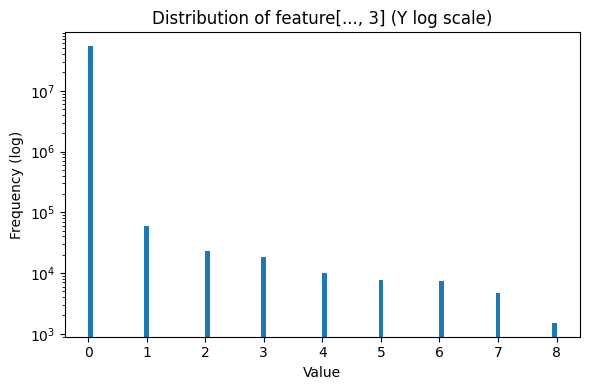

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载数据
data = np.load("/root/code/Time-Series-Library/dataset/sacramento_data.npy")

# 2. 取出最后一个维度（index=3）
feat = data[:, :, 3]

# 3. 打印统计信息
print("===== Feature Distribution (index = 3) =====")
print("Min:", np.min(feat))
print("Max:", np.max(feat))
print("Mean:", np.mean(feat))
print("Std:", np.std(feat))
print("Median:", np.median(feat))
print("25% quantile:", np.percentile(feat, 25))
print("75% quantile:", np.percentile(feat, 75))

# 4. 可视化直方图 (Y轴 log)
plt.figure(figsize=(6,4))
plt.hist(feat.flatten(), bins=100)
plt.yscale('log')  # 添加 log scale
plt.title("Distribution of feature[..., 3] (Y log scale)")
plt.xlabel("Value")
plt.ylabel("Frequency (log)")
plt.tight_layout()
plt.show()

Data shape: (105120, 517, 4)
Chosen station: 0
DOW stats (k, #no-acc, #mixed): [(0, 16, 37), (1, 18, 34), (2, 16, 36), (3, 15, 37), (4, 15, 37), (5, 12, 40), (6, 24, 28)]
Chosen DOW group: 5 (by day_id%7, START_DOW=0)
In chosen DOW=5: #no-acc=12, #mixed=40


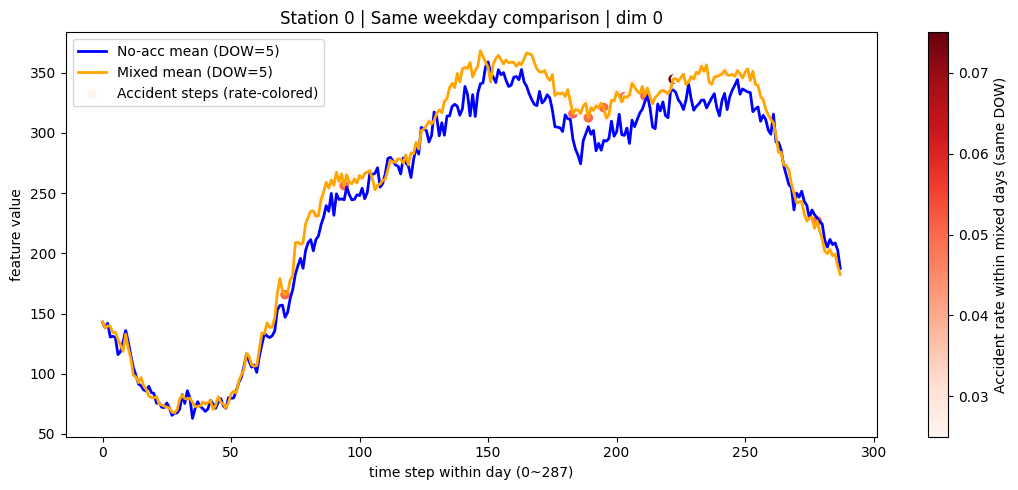

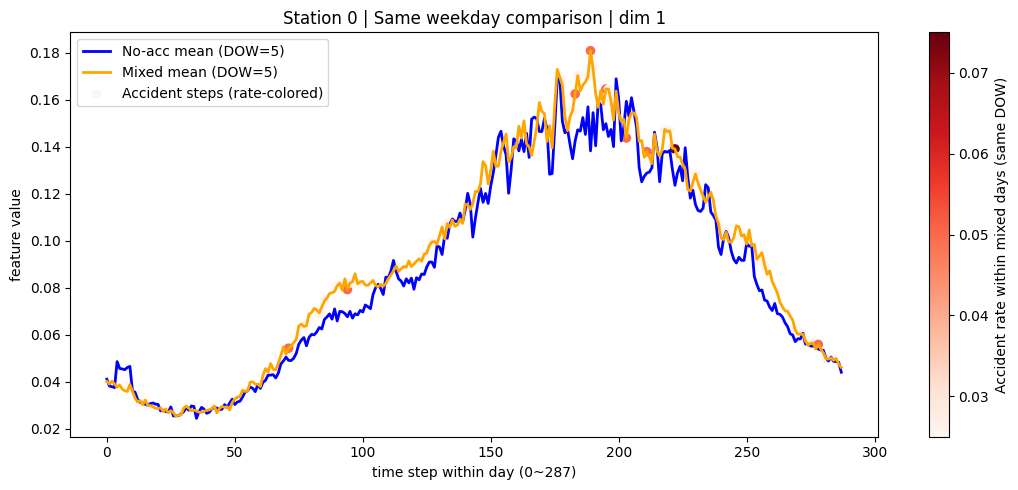

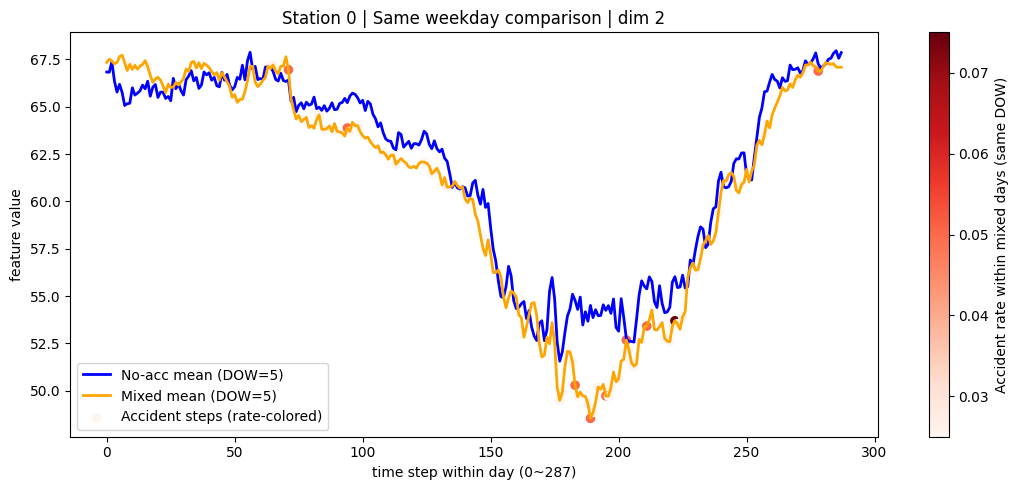

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. load data
# =========================
data = np.load("/root/code/Time-Series-Library/dataset/sacramento_data.npy")
T, N, F = data.shape
assert F == 4
print("Data shape:", data.shape)

labels = data[:, :, 3]
features = data[:, :, :3]

steps_per_day = 288
assert T % steps_per_day == 0
D = T // steps_per_day  # days

# reshape to (D, 288, ...)
feat_day = features.reshape(D, steps_per_day, N, 3)
lab_day  = labels.reshape(D, steps_per_day, N)

# =========================
# 2. pick station with most accident types (non-zero)
# =========================
station_unique_acc = []
for s in range(N):
    lab_s = labels[:, s]
    lab_s = lab_s[~np.isnan(lab_s)]
    uniq_nonzero = np.unique(lab_s[lab_s != 0])
    station_unique_acc.append(len(uniq_nonzero))

best_station = int(np.argmax(station_unique_acc))
print(f"Chosen station: {best_station}")

feat_s = feat_day[:, :, best_station, :]   # (D, 288, 3)
lab_s  = lab_day[:, :, best_station]       # (D, 288)

# =========================
# 3. group by day-of-week
# =========================
# 如果你知道第0天是周几，可在这里改：
# 0=周一,1=周二,...,5=周六,6=周日（仅作你自己理解用）
START_DOW = 0
dow = (np.arange(D) + START_DOW) % 7  # (D,)

# 找每个dow里纯无事故日、混合日的数量
dow_info = []
for k in range(7):
    days_k = np.where(dow == k)[0]
    lab_k  = lab_s[days_k]

    no_acc_mask_k = (lab_k == 0).all(axis=1)
    mix_mask_k    = (lab_k != 0).any(axis=1)

    num_no  = no_acc_mask_k.sum()
    num_mix = mix_mask_k.sum()
    dow_info.append((k, num_no, num_mix))

print("DOW stats (k, #no-acc, #mixed):", dow_info)

# 选择一个既有no-acc又有mixed的dow，优先mixed最多
valid_dows = [x for x in dow_info if x[1] > 0 and x[2] > 0]
if len(valid_dows) == 0:
    raise RuntimeError("No weekday group contains both no-accident and mixed days.")
chosen_dow = max(valid_dows, key=lambda x: x[2])[0]
print(f"Chosen DOW group: {chosen_dow} (by day_id%7, START_DOW={START_DOW})")

days_chosen = np.where(dow == chosen_dow)[0]
feat_c = feat_s[days_chosen]  # (Dc, 288, 3)
lab_c  = lab_s[days_chosen]   # (Dc, 288)

no_acc_mask = (lab_c == 0).all(axis=1)
mix_mask    = (lab_c != 0).any(axis=1)

no_acc_days = feat_c[no_acc_mask]   # (Dn, 288, 3)
mix_days    = feat_c[mix_mask]      # (Dm, 288, 3)
mix_labels  = lab_c[mix_mask]       # (Dm, 288)

print(f"In chosen DOW={chosen_dow}: #no-acc={no_acc_days.shape[0]}, #mixed={mix_days.shape[0]}")

# =========================
# 4. mean curves within same DOW
# =========================
curve_noacc = no_acc_days.mean(axis=0)        # (288, 3)
curve_mix   = mix_days.mean(axis=0)          # (288, 3)

# 每个时间步在 mixed days 中发生事故的频率
acc_rate = (mix_labels != 0).mean(axis=0)    # (288,)

# =========================
# 5. plot 3 figures (dims 0/1/2)
# =========================
x = np.arange(steps_per_day)
for d in range(3):
    plt.figure(figsize=(11,5))

    plt.plot(x, curve_noacc[:, d], linewidth=2, label=f"No-acc mean (DOW={chosen_dow})", color="blue")
    plt.plot(x, curve_mix[:, d],   linewidth=2, label=f"Mixed mean (DOW={chosen_dow})", color="orange")

    # 标出该dow的mixed days中，事故出现过的时间步（用频率上色）
    acc_steps = np.where(acc_rate > 0)[0]
    if len(acc_steps) > 0:
        sc = plt.scatter(
            acc_steps,
            curve_mix[acc_steps, d],
            c=acc_rate[acc_steps],
            s=35,
            cmap="Reds",
            label="Accident steps (rate-colored)"
        )
        cbar = plt.colorbar(sc)
        cbar.set_label("Accident rate within mixed days (same DOW)")

    plt.xlabel("time step within day (0~287)")
    plt.ylabel("feature value")
    plt.title(f"Station {best_station} | Same weekday comparison | dim {d}")
    plt.legend()
    plt.tight_layout()
    plt.show()

Data shape: (105120, 517, 4)
Chosen station: 20
DOW stats (k, #no-acc, #mixed): [(0, 28, 25), (1, 23, 29), (2, 24, 28), (3, 22, 30), (4, 29, 23), (5, 24, 28), (6, 26, 26)]
Chosen 5 DOWs: [3, 1, 2, 5, 6]


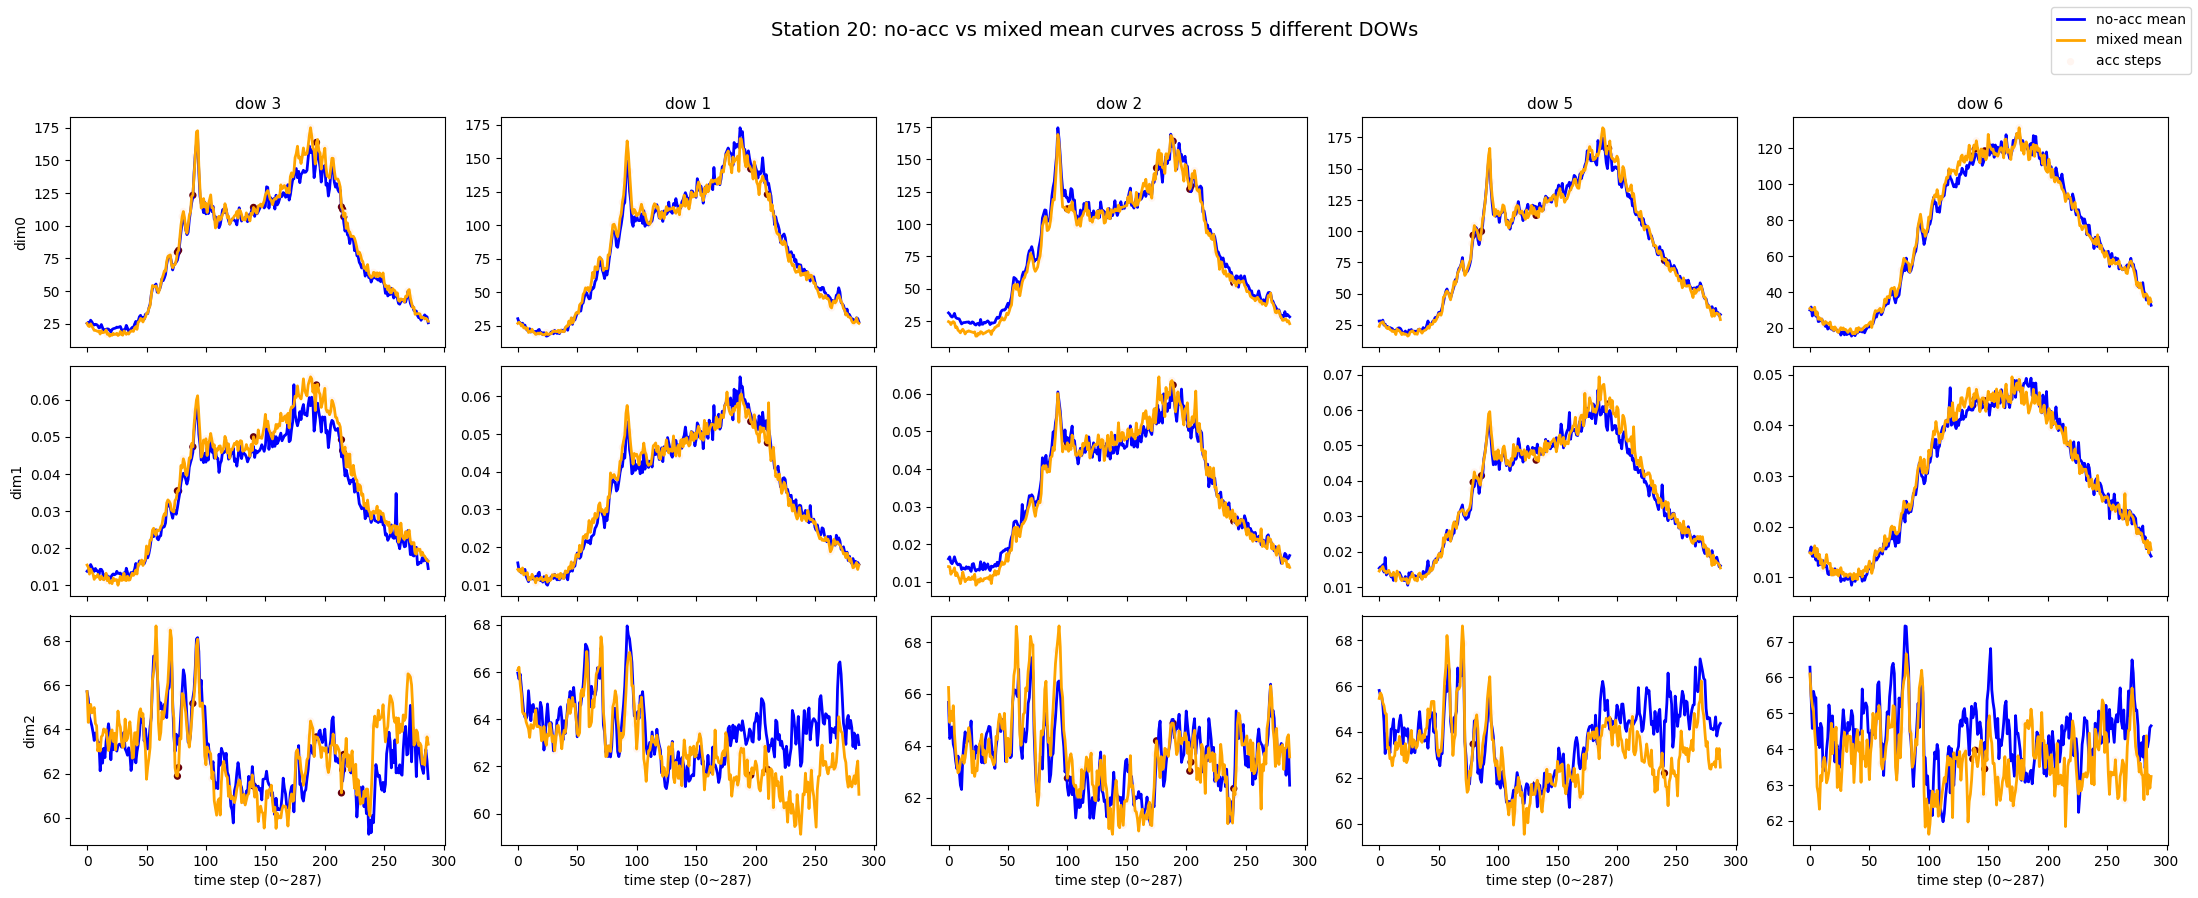

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. load data
# =========================
data = np.load("/root/code/Time-Series-Library/dataset/sacramento_data.npy")
T, N, F = data.shape
assert F == 4
print("Data shape:", data.shape)

labels = data[:, :, 3]
features = data[:, :, :3]

steps_per_day = 288
assert T % steps_per_day == 0
D = T // steps_per_day  # days

# reshape to (D, 288, ...)
feat_day = features.reshape(D, steps_per_day, N, 3)
lab_day  = labels.reshape(D, steps_per_day, N)

# =========================
# 2. pick station with most accident types (non-zero)
# =========================
station_unique_acc = []
for s in range(N):
    lab_s = labels[:, s]
    lab_s = lab_s[~np.isnan(lab_s)]
    uniq_nonzero = np.unique(lab_s[lab_s != 0])
    station_unique_acc.append(len(uniq_nonzero))

best_station = 20
print(f"Chosen station: {best_station}")

feat_s = feat_day[:, :, best_station, :]   # (D, 288, 3)
lab_s  = lab_day[:, :, best_station]       # (D, 288)

# =========================
# 3. group by day-of-week
# =========================
START_DOW = 0  # 不知道起始周几就保持0
dow = (np.arange(D) + START_DOW) % 7  # (D,)

# 预先存每个dow的曲线
curve_noacc = {}   # k -> (288,3)
curve_mix   = {}   # k -> (288,3)
acc_rate    = {}   # k -> (288,)

dow_stats = []     # (k, num_noacc, num_mix)

for k in range(7):
    days_k = np.where(dow == k)[0]
    if len(days_k) == 0:
        continue

    feat_k = feat_s[days_k]  # (Dk, 288, 3)
    lab_k  = lab_s[days_k]   # (Dk, 288)

    no_acc_mask_k = (lab_k == 0).all(axis=1)   # 纯无事故日
    mix_mask_k    = (lab_k != 0).any(axis=1)   # 有事故日

    num_no  = int(no_acc_mask_k.sum())
    num_mix = int(mix_mask_k.sum())
    dow_stats.append((k, num_no, num_mix))

    if num_no > 0:
        curve_noacc[k] = feat_k[no_acc_mask_k].mean(axis=0)

    if num_mix > 0:
        mix_feat   = feat_k[mix_mask_k]
        mix_labels = lab_k[mix_mask_k]
        curve_mix[k] = mix_feat.mean(axis=0)
        acc_rate[k]  = (mix_labels != 0).mean(axis=0)

print("DOW stats (k, #no-acc, #mixed):", dow_stats)

# =========================
# 4. choose 5 dows that have both no-acc and mixed
# =========================
valid_dows = [x for x in dow_stats if x[1] > 0 and x[2] > 0]
if len(valid_dows) == 0:
    raise RuntimeError("No DOW group contains both no-accident and mixed days.")

# 优先 mixed 数量多的 dow
valid_dows = sorted(valid_dows, key=lambda x: x[2], reverse=True)
chosen_dows = [x[0] for x in valid_dows[:5]]

# 如果不足5个，就按 mixed 多的补齐（即使没有no-acc或mixed会缺线，但一般够）
if len(chosen_dows) < 5:
    rest = sorted(dow_stats, key=lambda x: x[2], reverse=True)
    for r in rest:
        if r[0] not in chosen_dows:
            chosen_dows.append(r[0])
        if len(chosen_dows) == 5:
            break

print("Chosen 5 DOWs:", chosen_dows)

# =========================
# 5. plot 3x5 matrix: two curves per subplot
# =========================
x = np.arange(steps_per_day)
dim_titles = ["dim0", "dim1", "dim2"]

fig, axes = plt.subplots(3, 5, figsize=(22, 9), sharex=True)

for col, k in enumerate(chosen_dows):

    no_curve = curve_noacc.get(k, None)
    mix_curve = curve_mix.get(k, None)
    rate = acc_rate.get(k, None)

    for row in range(3):
        ax = axes[row, col]

        # 无事故均值曲线（蓝）
        if no_curve is not None:
            ax.plot(x, no_curve[:, row], linewidth=2, label="no-acc mean", color="blue")

        # 有事故均值曲线（橙）
        if mix_curve is not None:
            ax.plot(x, mix_curve[:, row], linewidth=2, label="mixed mean", color="orange")

            # 事故出现过的时间步标记（红色渐变点）
            if rate is not None:
                acc_steps = np.where(rate > 0)[0]
                if len(acc_steps) > 0:
                    sc = ax.scatter(
                        acc_steps,
                        mix_curve[acc_steps, row],
                        c=rate[acc_steps],
                        s=18,
                        cmap="Reds",
                        label="acc steps"
                    )

        if row == 0:
            ax.set_title(f"dow {k}", fontsize=11)
        if col == 0:
            ax.set_ylabel(dim_titles[row])
        if row == 2:
            ax.set_xlabel("time step (0~287)")

# 只放一个总图例
handles, labels_ = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="upper right")

plt.suptitle(f"Station {best_station}: no-acc vs mixed mean curves across 5 different DOWs", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import os
import argparse
import numpy as np
import pandas as pd

class StandardScaler():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean


# def generate_data_and_idx(df, x_offsets, y_offsets, add_time_of_day, add_day_of_week):
#     num_samples, num_nodes = df.shape
#     data = np.expand_dims(df.values, axis=-1)
    
#     feature_list = [data]
#     if add_time_of_day:
#         time_ind = (df.index.values - df.index.values.astype('datetime64[D]')) / np.timedelta64(1, 'D')
#         time_of_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
#         feature_list.append(time_of_day)
#     if add_day_of_week:
#         dow = df.index.dayofweek
#         dow_tiled = np.tile(dow, [1, num_nodes, 1]).transpose((2, 1, 0))
#         day_of_week = dow_tiled / 7
#         feature_list.append(day_of_week)

#     data = np.concatenate(feature_list, axis=-1)
    
#     min_t = abs(min(x_offsets))
#     max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
#     print('idx min & max:', min_t, max_t)
#     idx = np.arange(min_t, max_t, 1)
#     return data, idx

def generate_data_and_idx(data, timestamps,
                          x_offsets, y_offsets,
                          add_time_of_day=True,
                          add_day_of_week=True):
    """
    data: np.ndarray, shape (num_samples, num_nodes, feature_dim)
    timestamps: pd.DatetimeIndex, len == num_samples
    """
    # 1. 基本形状
    data = np.asarray(data)
    num_samples, num_nodes, feature_dim = data.shape

    feature_list = [data]  # (T, N, F)

    # 2. time of day 特征 (T, N, 1)
    if add_time_of_day:
        # 一天中的小数（0~1）
        time_ind = (timestamps.values - timestamps.values.astype('datetime64[D]')) / np.timedelta64(1, 'D')
        # time_ind: (T,) -> (T, 1, 1) -> tile 到 (T, N, 1)
        time_of_day = np.tile(time_ind[:, None, None], (1, num_nodes, 1)).astype(np.float32)
        feature_list.append(time_of_day)

    # 3. day of week 特征 (T, N, 1)
    if add_day_of_week:
        dow = timestamps.dayofweek.values  # (T,)
        dow_norm = (dow / 7.0).astype(np.float32)
        day_of_week = np.tile(dow_norm[:, None, None], (1, num_nodes, 1))  # (T, N, 1)
        feature_list.append(day_of_week)

    # 4. 拼接到 feature 维度
    data_with_feat = np.concatenate(feature_list, axis=-1)  # (T, N, F + extra)

    # 5. 生成可用的时间索引 idx
    min_t = abs(min(x_offsets))
    max_t = num_samples - abs(max(y_offsets))  # 注意这里不用再 abs 一次 num_samples

    print('idx min & max:', min_t, max_t)
    idx = np.arange(min_t, max_t, 1)

    return data_with_feat, idx

def generate_train_val_test(args, data_3d):


    seq_length_x, seq_length_y = args.seq_length_x, args.seq_length_y
    x_offsets = np.arange(-(seq_length_x - 1), 1, 1)
    y_offsets = np.arange(1, (seq_length_y + 1), 1)

    data, idx = generate_data_and_idx(df, x_offsets, y_offsets, args.tod, args.dow)
    print('final data shape:', data.shape, 'idx shape:', idx.shape)

    num_samples = len(idx)
    num_train = round(num_samples * 0.6)
    num_val = round(num_samples * 0.2)   

    # split idx
    idx_train = idx[:num_train]
    idx_val = idx[num_train: num_train + num_val]
    idx_test = idx[num_train + num_val:]

    # normalize
    x_train = data[:idx_val[0] - args.seq_length_x, :, 0] 
    scaler = StandardScaler(mean=x_train.mean(), std=x_train.std())
    data[..., 0] = scaler.transform(data[..., 0])

    # save
    out_dir = '/root/code/Xtraffic_data'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    np.savez_compressed(os.path.join(out_dir, 'his.npz'), data=data, mean=scaler.mean, std=scaler.std)

    np.save(os.path.join(out_dir, 'idx_train'), idx_train)
    np.save(os.path.join(out_dir, 'idx_val'), idx_val)
    np.save(os.path.join(out_dir, 'idx_test'), idx_test)


parser = argparse.ArgumentParser()
parser.add_argument('--seq_length_x', type=int, default=12, help='sequence Length')
parser.add_argument('--seq_length_y', type=int, default=12, help='sequence Length')
parser.add_argument('--tod', type=int, default=1, help='time of day')
parser.add_argument('--dow', type=int, default=1, help='day of week')
args = parser.parse_args()

data_3d = sac_data
generate_train_val_test(args, data_3d)


# 4. 制作时间维度的特征：时间戳、天气


# 5. 制作节点维度的特征：图像、POI、节点类型road_type、邻接矩阵、距离矩阵

    1. 先制作
    2. 根据符合要求的节点id或者idx进行筛选

事件字段

| 字段名              | 数据类型 | 非缺失数  | 缺失数 | 缺失占比(%) | 唯一值数 |
|---------------------|----------|-----------|--------|-------------|----------|
| duration            | float64  | 469,279   | 7,489  | 1.57        | 1,366    |
| AREA                | object   | 472,980   | 3,788  | 0.79        | 174      |
| Freeway_direction   | object   | 474,010   | 2,758  | 0.58        | 8        |
| Latitude            | float64  | 474,212   | 2,556  | 0.54        | 30,317   |
| Longitude           | object   | 474,212   | 2,556  | 0.54        | 30,559   |
| Abs PM              | float64  | 474,227   | 2,541  | 0.53        | 6,273    |
| incident_id         | object   | 476,768   | 0      | 0           | 476,767  |
| Fwy                 | float64  | 476,766   | 2      | 0           | 178      |
| DESCRIPTION         | object   | 476,768   | 0      | 0           | 49       |
| LOCATION            | object   | 476,768   | 0      | 0           | 43,303   |
| dt                  | object   | 476,766   | 2      | 0           | 317,012  |
| Type                | object   | 476,768   | 0      | 0           | 8        |

## 5.1 邻接矩阵和距离矩阵

In [41]:
# 距离矩阵和邻接矩阵构建
full_adj_path = data_dir / "adj_matrix.npy"
full_dist_path = data_dir / "dis_matrix.npy"
full_adj = np.load(full_adj_path)    # (N_all, N_all)
full_dist = np.load(full_dist_path)  # (N_all, N_all)
sac_adj  = full_adj[np.ix_(sac_node_indices, sac_node_indices)]
sac_dist = full_dist[np.ix_(sac_node_indices, sac_node_indices)]
# 对角矩阵制为1
np.fill_diagonal(sac_adj, 1)
print(sac_adj.shape,sac_dist.shape)
# 保存 sac_adj 和 sac_dist
sac_adj_path = save_path / "sacramento_adj.npy"
sac_dist_path = save_path / "sacramento_dist.npy"
np.save(sac_adj_path, sac_adj)
np.save(sac_dist_path, sac_dist)

(517, 517) (517, 517)


In [16]:
import numpy as np
sac_dist = np.load(save_path / "sacramento_dist.npy")
def build_adj_from_dist(dist_matrix, method="gaussian", threshold=1000, sigma=None, k=10):
    """
    基于距离矩阵构造邻接矩阵
    method: ["threshold", "gaussian", "knn"]
    """
    dist = dist_matrix.copy()
    
    # 避免对角线影响
    np.fill_diagonal(dist, 0)

    N = dist.shape[0]
    A = np.zeros_like(dist, dtype=float)

    if method == "threshold":
        # 距离小于阈值 -> 连边
        A = (dist <= threshold).astype(float)
        np.fill_diagonal(A, 1)

    elif method == "gaussian":
        if sigma is None:
            # 这里选用中位数作为 sigma，更稳定
            sigma = np.median(dist[dist > 0])
        A = np.exp(-(dist ** 2) / (sigma ** 2))
        np.fill_diagonal(A, 1)

    elif method == "knn":
        for i in range(N):
            # 排除自己
            row = dist[i].copy()
            row[i] = np.inf
            # 取最小 k 个距离
            knn_idx = np.argpartition(row, k)[:k]
            A[i, knn_idx] = 1
        np.fill_diagonal(A, 1)

    else:
        raise ValueError("method 必须是 threshold / gaussian / knn")

    return A


sac_adj_new = build_adj_from_dist(sac_dist, method="gaussian")
np.save(save_path / "sacramento_adj_gaussian.npy", sac_adj_new)
print(sac_adj_new)

[[1.00000000e+00 9.99999975e-01 7.76061327e-01 ... 9.99999975e-01
  9.99999975e-01 9.99999975e-01]
 [9.99999975e-01 1.00000000e+00 9.99999975e-01 ... 9.99999975e-01
  9.99999975e-01 9.99999975e-01]
 [4.58682033e-04 9.99999975e-01 1.00000000e+00 ... 6.07367525e-01
  9.99999975e-01 9.99999975e-01]
 ...
 [9.99999975e-01 9.99999975e-01 1.07523989e-01 ... 1.00000000e+00
  9.99999975e-01 9.99999975e-01]
 [9.99999975e-01 9.99999975e-01 9.99999975e-01 ... 9.99999975e-01
  1.00000000e+00 9.99999975e-01]
 [9.99999975e-01 9.99999975e-01 9.99999975e-01 ... 9.99999975e-01
  9.99999975e-01 1.00000000e+00]]


In [13]:
# sac_node_indices 是全局 node_index（即 node_order 的位置）
station_ids = node_order[sac_node_indices].astype(int)

df_final = pd.DataFrame({
    "station_id": station_ids,
    "node_index": sac_node_indices
})

print(df_final.head())
city_df = duckdb.query("""
SELECT 
    A.Type,
    A.station_id,
    K.node_index
FROM df_meta AS A
JOIN df_final AS K
    ON A.station_id = K.station_id
ORDER BY A.County, K.node_index
""").to_df()
print(city_df.head())
city_df.to_csv(save_path/"sacramento_sensor_type.csv")


   station_id  node_index
0      314421           2
1      314615          39
2      315883         101
3      315901         110
4      317138         126
       Type  station_id  node_index
0  Off Ramp      314421           2
1  Off Ramp      314615          39
2       HOV      315883         101
3       HOV      315901         110
4  Off Ramp      317138         126


In [ ]:
import numpy as np

data = np.load('flow_hamburg_new_matrix.npy')
print(data.shape)

nan_count = np.isinf(data).sum()
print(f"数组中NaN值的总数: {nan_count}")
valid_distances = data[np.isfinite(data)]
print(valid_distances.shape)
print(valid_distances)
sigma = np.std(valid_distances)
print(sigma)
gaussian_kernel = np.exp(-(data**2)/(sigma**2))
print(gaussian_kernel)
A = np.where(gaussian_kernel >= 0.01, gaussian_kernel, 0)
print(A)
zero_count = (A == 0).sum()
print("0 的个数:", zero_count)  # 输出 3
#print(np.exp(-(np.inf**2)/(sigma**2)))
np.save("flow_hamburg_rn_adj.npy",A)

In [19]:
import pandas as pd
import numpy as np
# ------------------------------
# Haversine 距离（单位：米）
# ------------------------------
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    输入：纬度/经度 (°)
    输出：两点之间的距离 (米)
    """
    R = 6371000  # 地球半径（米）

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# ------------------------------
# 主逻辑
# ------------------------------
csv_path = "city_lat_lng.csv"
df = pd.read_csv(csv_path)

# 你的 node index 列表 sac_node_indices（举例）
# sac_node_indices = [10, 25, 103, ...]
# 保证是 list 或 numpy array
# sac_node_indices = np.load("your_path.npy")

# 1) 按 node_index 过滤并且保持原来顺序
df_sub = df[df["node_index"].isin(sac_node_indices)]
df_sub = df_sub.set_index("node_index").loc[sac_node_indices].reset_index()

# 提取经纬度
lats = df_sub["Lat"].values
lngs = df_sub["Lng"].values

n = len(df_sub)
dist_matrix = np.zeros((n, n), dtype=np.float64)

# 2) 构造距离矩阵
for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = haversine_distance(
            lats[i], lngs[i],
            lats[j], lngs[j]
        )

# 3) 输出结果
print("Distance matrix shape:", dist_matrix.shape)
print(dist_matrix)

# 你也可以保存
# np.save("sacramento_dist_matrix.npy", dist_matrix)

Distance matrix shape: (517, 517)
[[    0.         24881.73200698  3190.33182768 ...  5913.33303901
  11171.24298267  9121.0389864 ]
 [24881.73200698     0.         21995.40480925 ... 19604.55891991
  17503.21700448 19278.64797237]
 [ 3190.33182768 21995.40480925     0.         ...  2723.00273003
  10058.48691806  6209.68617031]
 ...
 [ 5913.33303901 19604.55891991  2723.00273003 ...     0.
   9850.63939277  4073.21886023]
 [11171.24298267 17503.21700448 10058.48691806 ...  9850.63939277
      0.         13314.99458149]
 [ 9121.0389864  19278.64797237  6209.68617031 ...  4073.21886023
  13314.99458149     0.        ]]


In [20]:
import numpy as np

# ------------------------------------------------------
# 1. 读取距离矩阵（你也可以直接用 dist_matrix 变量替换）
# ------------------------------------------------------
# dist_matrix = np.load("sacramento_dist_matrix.npy")
# 或者如果你在当前运行的同一个脚本里：
# dist_matrix = dist_matrix

data = dist_matrix.copy()  # 确保变量名一致
print("Distance matrix shape:", data.shape)

# ------------------------------------------------------
# 2. 检查是否有 inf/NaN
# ------------------------------------------------------
nan_count = np.isinf(data).sum() + np.isnan(data).sum()
print(f"NaN/Inf 总数: {nan_count}")

# 过滤掉无效值
valid_distances = data[np.isfinite(data)]
print("有效距离数量:", valid_distances.shape)
# print(valid_distances)

# ------------------------------------------------------
# 3. 计算 sigma
# ------------------------------------------------------
sigma = np.std(valid_distances)
print("sigma =", sigma)

# ------------------------------------------------------
# 4. 高斯核相似度矩阵
#    K_ij = exp(-(d_ij^2) / sigma^2)
# ------------------------------------------------------
gaussian_kernel = np.exp(-(data ** 2) / (sigma ** 2))
print("Gaussian kernel matrix computed.")

# ------------------------------------------------------
# 5. 阈值过滤：小于 0.01 的全部置 0
# ------------------------------------------------------
A = np.where(gaussian_kernel >= 0.01, gaussian_kernel, 0)
print("邻居矩阵 A 已生成，形状:", A.shape)

# ------------------------------------------------------
# 6. 统计 0 的个数
# ------------------------------------------------------
zero_count = (A == 0).sum()
print(f"A 中 0 的个数: {zero_count}")

# ------------------------------------------------------
# 7. 保存邻居矩阵
# ------------------------------------------------------
np.save("sacramento_adj_gaussian.npy", A)
print("已保存到 sacramento_adj_gaussian.npy")

Distance matrix shape: (517, 517)
NaN/Inf 总数: 0
有效距离数量: (267289,)
sigma = 12519.391953579503
Gaussian kernel matrix computed.
邻居矩阵 A 已生成，形状: (517, 517)
A 中 0 的个数: 56276
已保存到 sacramento_adj_gaussian.npy
